In [ ]:
import torch
import numpy as np
from torch import nn 
import random
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
imiona = open("imionapl.txt", encoding = "UTF-8").read().splitlines()
imiona = [i.lower() for i in imiona]
imiona[:5]

['ada', 'adalbert', 'adam', 'adela', 'adelajda']

In [ ]:
chars = sorted(list(set(''.join(imiona))))
stoi = {s:i +1  for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i :s for s, i in stoi.items()}
vocab_size = len(itos)
print(vocab_size)

31


In [ ]:
logits_1 = torch.tensor([0.1,0.1,0.1,0.7 ])
logits_2 = torch.randn(4) * 10
print(logits_1, logits_2)
probs_1 = torch.softmax(logits_1, dim = 0)
probs_2 = torch.softmax(logits_2, dim = 0)
loss_1 = -probs_1[3].log()
loss_2 = -probs_2[3].log()
loss_1, loss_2

tensor([0.1000, 0.1000, 0.1000, 0.7000]) tensor([-2.8660,  8.0372, -3.4506,  8.1401])


(tensor(0.9732), tensor(0.6430))

In [ ]:
block_size = 3 
def build_dataset(imiona):  
    X, Y = [], []
    for w in imiona:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
random.seed(42)
random.shuffle(imiona)
n1 = int(0.8*len(imiona))
n2 = int(0.9*len(imiona))

X_train, Y_train = build_dataset(imiona[:n1])
X_dev, Y_dev = build_dataset(imiona[n1:n2])
X_test, Y_test = build_dataset(imiona[n2:])
    

torch.Size([3919, 3]) torch.Size([3919])
torch.Size([510, 3]) torch.Size([510])
torch.Size([480, 3]) torch.Size([480])


In [ ]:
def model(X_train,Y_train, batch_size, parameters, max_steps):
    losses, accuracies = [],[]
    C, W1, W2, b1, b2 = parameters
    for i in range(max_steps):

        # minibatch construct
        ix = torch.randint(0, X_train.shape[0], (32,))
        X_batched, Y_batched = X_train[ix], Y_train[ix]
        # forward pass
        emb = C[X_batched]
        #print(f"""emb :{emb.shape}""")
        embcat = emb.view(emb.shape[0], -1)
        # Linear layer
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y_batched)
        cat = torch.argmax(logits, dim=1)
        accuracy = (cat == Y_batched).float().mean()
        if i % 100 == 0:
            print(f"""loss :{loss.item()}, accuracy :{accuracy.item()}""")
        losses.append(loss.item())
        accuracies.append(accuracy.item())
        #backward
        for p in parameters:
            p.grad = None
        loss.backward()


        for p in parameters:
            p.data += -0.15 * p.grad

    plt.plot(np.arange(max_steps), losses);
    plt.plot(np.arange(max_steps), accuracies);

# Fixing initial loss

In [ ]:
dims = 10 
hidden_neurons = 200

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, dims))
W1 = torch.randn((dims*block_size, hidden_neurons), generator = g)
b1 = torch.randn((hidden_neurons), generator = g)
W2 = torch.randn((hidden_neurons, vocab_size), generator = g)
b2 = torch.randn((vocab_size), generator = g)

W1_2 = torch.randn((dims*block_size, hidden_neurons), generator = g)* 0.02
b1_2 = torch.randn((hidden_neurons), generator = g) * 0
W2_2 = torch.randn((hidden_neurons, vocab_size), generator = g)* 0.02
b2_2 = torch.randn((vocab_size), generator = g)* 0 


parameters = [C, W1, W2, b1, b2]
parameters_2 = [C, W1_2, W2_2, b1_2, b2_2]
def enable_grad(parameters):
    for p in parameters:
        p.requires_grad = True
enable_grad(parameters)
enable_grad(parameters_2)

loss :24.90995979309082, accuracy :0.0
loss :6.833872318267822, accuracy :0.375
loss :4.890115737915039, accuracy :0.28125
loss :5.290096282958984, accuracy :0.40625
loss :3.540456533432007, accuracy :0.3125
loss :3.4882383346557617, accuracy :0.375
loss :2.6352570056915283, accuracy :0.46875
loss :2.5217010974884033, accuracy :0.40625
loss :3.1989269256591797, accuracy :0.3125
loss :2.223512887954712, accuracy :0.5
loss :3.432651996612549, accuracy :0.03125
loss :2.5467381477355957, accuracy :0.28125
loss :2.583127021789551, accuracy :0.3125
loss :2.695267677307129, accuracy :0.34375
loss :2.2445592880249023, accuracy :0.28125
loss :2.0187325477600098, accuracy :0.375
loss :2.253755569458008, accuracy :0.375
loss :2.276005268096924, accuracy :0.25
loss :2.3481175899505615, accuracy :0.34375
loss :2.549595594406128, accuracy :0.28125


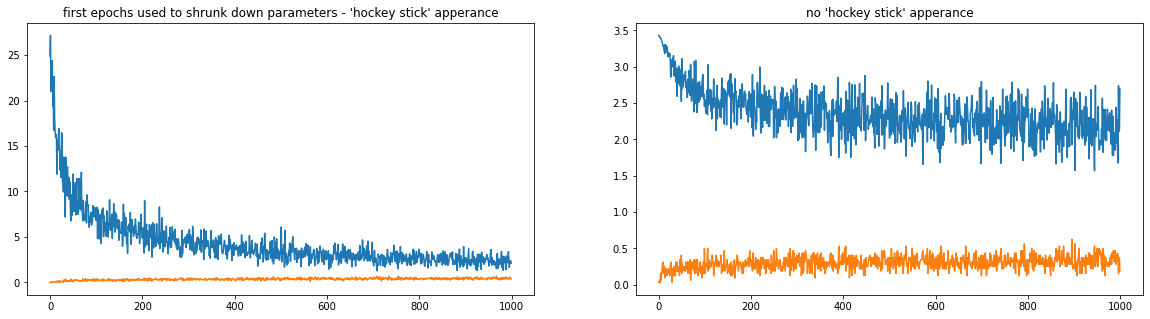

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.title("first epochs used to shrunk down parameters - 'hockey stick' apperance")
model(X_train, Y_train, 32, parameters, 1000)
plt.subplot(122)
plt.title("no 'hockey stick' apperance")
model(X_train, Y_train, 32, parameters_2, 1000)

# saturated tanh

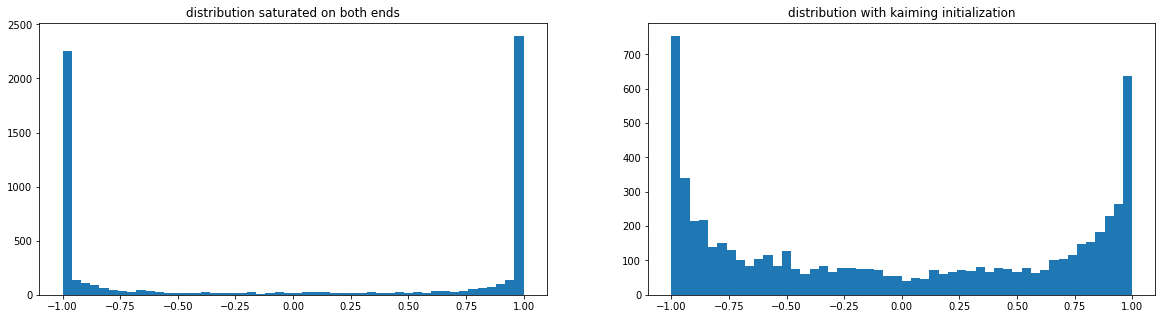

In [ ]:
#saturated tanh 
# https://pytorch.org/docs/stable/nn.init.html
plt.figure(figsize = (20,5))
W1_3 = torch.randn((dims*block_size, hidden_neurons), generator = g) * (5/3)/((dims*block_size)**0.5) #5/3 is a fixed value for tanh activation known as "gain"
b1_3 = torch.randn((hidden_neurons), generator = g) * 0 
W2_3 = torch.randn((hidden_neurons, vocab_size), generator = g)* (5/3)/((hidden_neurons)**0.5)
b2_3 = torch.randn((vocab_size), generator = g) * 0 

parameters_3 = [C, W1_3, W2_3, b1_3,b2_3]

h= torch.tanh(C[X_train[:32]].view(-1,W1.shape[0]) @ W1 + b1)
h_3 = torch.tanh(C[X_train[:32]].view(-1,W1_3.shape[0]) @ W1_3 + b1_3)

plt.subplot(121)
plt.hist(h.view(-1).tolist(), bins = 50);
plt.title("distribution saturated on both ends");
plt.subplot(122)
plt.hist(h_3.view(-1).tolist(), bins = 50);

plt.title("distribution with kaiming initialization");

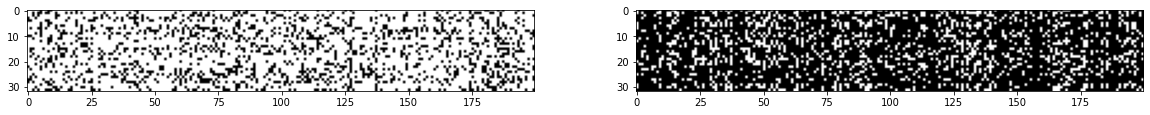

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.imshow(h.abs() > 0.99, cmap = "gray")
plt.subplot(122)
plt.imshow(h_3.abs() > 0.99, cmap = "gray")

tensor(-0.0014) tensor(1.0010)
tensor(0.0016) tensor(3.1713)
tensor(0.0016) tensor(0.9960)


Text(0.5, 1.0, 'preserved std')

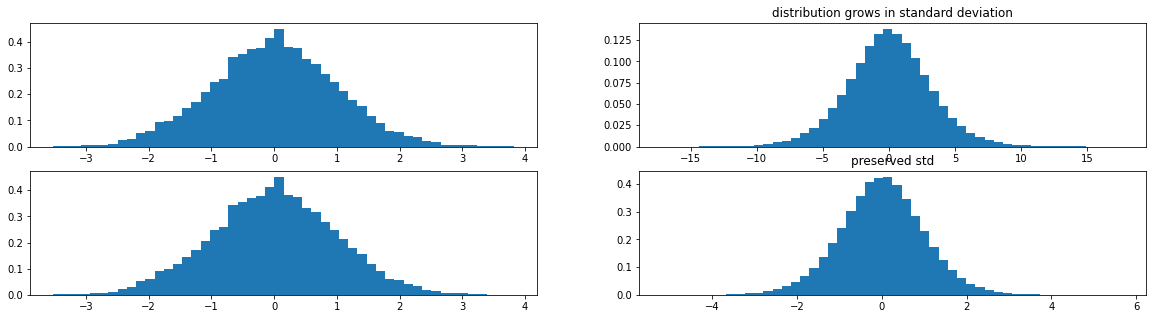

In [ ]:
x = torch.randn(1000,10)
w = torch.randn(10, 200)
w_kaiming = torch.randn(10, 200) / (w.shape[0])**0.5  #to preserve distribution to remain gaussian 
y = x @ w
y_kaiming = x @ w_kaiming 
print(x.mean(), x.std())
print(y.mean(), y.std())
print(y.mean(), y_kaiming.std()) # we want relatively similar activations (unit gaussian) throught the neural net

plt.figure(figsize = (20,5))
plt.subplot(221)
plt.hist(x.view(-1).tolist(), bins = 50, density=True);
plt.subplot(222)
plt.hist(y.view(-1).tolist(), bins = 50, density=True);
plt.title("distribution grows in standard deviation")
plt.subplot(223)
plt.hist(x.view(-1).tolist(), bins = 50, density=True);
plt.subplot(224)
plt.hist(y_kaiming.view(-1).tolist(), bins = 50, density=True);
plt.title("preserved std")


In [ ]:
enable_grad(parameters_3)

loss :25.49611473083496, accuracy :0.0625
loss :8.474879264831543, accuracy :0.1875
loss :5.978255271911621, accuracy :0.28125
loss :6.994248390197754, accuracy :0.21875
loss :3.7491114139556885, accuracy :0.25
loss :2.685087203979492, accuracy :0.5
loss :2.7258901596069336, accuracy :0.34375
loss :2.1223628520965576, accuracy :0.5
loss :2.989577293395996, accuracy :0.34375
loss :1.8947030305862427, accuracy :0.46875
loss :3.4399402141571045, accuracy :0.0625
loss :2.5654497146606445, accuracy :0.25
loss :2.114891767501831, accuracy :0.4375
loss :1.7745734453201294, accuracy :0.5
loss :2.455580234527588, accuracy :0.28125
loss :2.410226345062256, accuracy :0.3125
loss :2.2646644115448, accuracy :0.34375
loss :2.3934683799743652, accuracy :0.25
loss :2.0578737258911133, accuracy :0.5
loss :2.2388296127319336, accuracy :0.3125
loss :4.090330123901367, accuracy :0.03125
loss :2.4792122840881348, accuracy :0.21875
loss :2.4696505069732666, accuracy :0.28125
loss :1.9771665334701538, accura

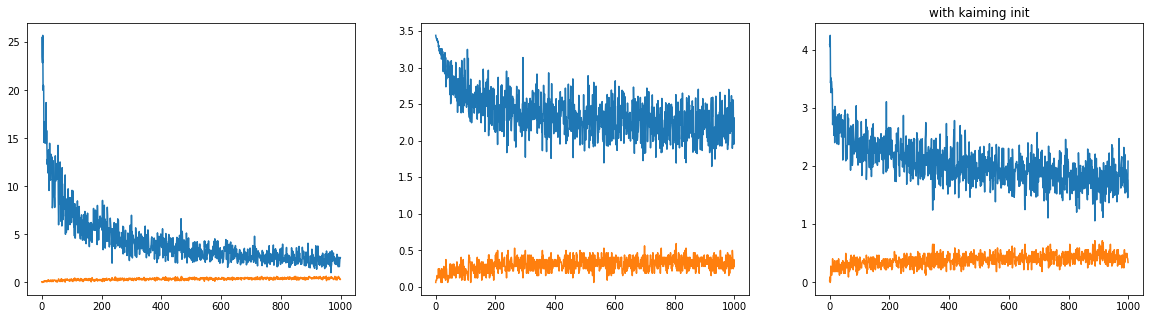

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(131)
model(X_train,Y_train, 32, parameters, 1000)
plt.subplot(132)
model(X_train,Y_train,32, parameters_2, 1000)
plt.subplot(133)
plt.title("with kaiming init")
model(X_train,Y_train, 32, parameters_3, 1000)

In [ ]:

with torch.no_grad():
    def split_loss(split_x, split_y, parameters):
        C, W1, W2, b1, b2 = parameters
        emb = C[split_x] # (N, block_size, n_embd)
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1  + b1
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        loss = F.cross_entropy(logits, split_y)
        print(f"""loss :{loss.item()}""")
print("losses for parameters_3")
split_loss(X_train, Y_train, parameters_3 )
split_loss(X_test, Y_test, parameters_3)

print("losses for parameters_2")
split_loss(X_train, Y_train, parameters_2 )
split_loss(X_test, Y_test, parameters_2)

print("losses for parameters")
split_loss(X_train, Y_train, parameters)
split_loss(X_test, Y_test, parameters)

losses for parameters_3
loss :1.7594282627105713
loss :2.2369918823242188
losses for parameters_2
loss :2.1897504329681396
loss :2.2759366035461426
losses for parameters
loss :4.778420925140381
loss :6.3108086585998535
